In [31]:

import pandas as pd
import random 
import sys
import os
import torch.nn as nn

from scipy.stats import uniform, randint

# from ray import tune
# from ray.tune.schedulers import ASHAScheduler

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
notebooks_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebooks_dir, os.pardir))

# Add the project root directory to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

try:
    from utils.model_utils import train, predict, evaluate, inverse_normalize
    from utils.process_data import get_processed_data, prepare_datasets, create_mapping_from_one_hot
    from models.cnn_v2 import CNNV2
    from utils.parameter_tuning import random_search
    from utils.plots import plot_losses, plot_predictions_vs_labels, plot_predictions_vs_labels_by_species\
    , plot_boxplot_predictions_vs_labels, plot_hexbin_predictions_vs_labels, plot_histogram
    print("Import successful")
except ImportError as e:
    print(f"Error importing module: {e}")


Import successful


# Load Data and Test Different Normalizations

In [41]:
processed_data_path = f"{project_root}/data/processed_data_1h.pkl"
if os.path.exists(processed_data_path):
    data_df = pd.read_pickle(processed_data_path)
else:
   data_df = get_processed_data(project_root) 

In [44]:
one_hot_to_species = create_mapping_from_one_hot(df=data_df, one_hot_column='species_1h', other_column='species_id')
one_hot_to_condition = create_mapping_from_one_hot(df=data_df, one_hot_column='stress_name_1h', other_column='stress_name')

In [46]:
one_hot_to_species

{0: 'ACHX',
 1: 'ACIB',
 2: 'AGGA',
 3: 'BBURG',
 4: 'BURK',
 5: 'Campy',
 6: 'ENTFA',
 7: 'EPEC',
 8: 'ETEC',
 28: 'UPEC',
 9: 'FRAT',
 10: 'HINF',
 11: 'HPG27',
 12: 'HPJ99',
 13: 'KLEBS',
 14: 'LEGIP',
 15: 'Listeria',
 18: 'MTB',
 19: 'NGON',
 20: 'NMEN',
 21: 'PSEUDO',
 22: 'SALMT',
 16: 'MRSA',
 17: 'MSSA',
 23: 'SEPI',
 26: 'STAGA',
 27: 'STRPN',
 24: 'SPYO',
 25: 'SSUIS',
 29: 'Vibrio'}

In [49]:
data_df = data_df.drop(columns=['species', 'species_id', 'upstream200', 'stress_name'])
data_df

,species_1h,upstream200_1h,tpm,stress_name_1h
0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",-0.079613,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",-0.026784,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",-0.624611,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
3,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",0.617587,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
4,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",0.922333,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
...,...,...,...,...
972069,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[1, 0, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",-0.136352,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
972070,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[1, 0, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",0.466818,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
972071,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[1, 0, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",0.330432,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
972072,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[1, 0, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",0.372162,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"


In [4]:
data_df.describe()

,stress
count,972074.000000
mean,0.043495
std,0.881878
min,-9.322945
25%,-0.339275
50%,0.036262
75%,0.418981
max,8.911650


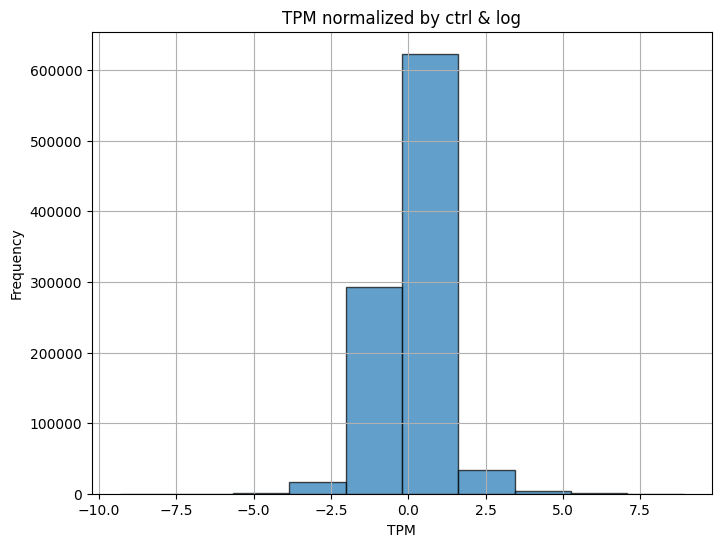

In [53]:
plot_histogram(data_df['tpm'], title=f'TPM normalized by ctrl & log', xlabel='TPM', bins=10)


# Model Training

In [26]:
config = {'lr': 0.008627652999200546,
 'cnn_filters': 122,
 'batch_size': 999,
 'hidden_size': 69,
 'activation': nn.ReLU(),
 'epochs': 10,
 'species_id': -1,
 'test_size': 20000,
 'model_version': 1,
 'kernel_size': 4,
 'stress_condition_size': 11}

In [71]:
config = {
    'lr': 0.0001,
    'batch_size': 64,
    'epochs': 15,
    'species_id': -1,
    'test_size': -1,
    'hidden_size': 16,
    'cnn_filters': 16,
    'model_version': 1,
    'stress_condition_size': 11,
    'kernel_size': 9,
    'stride': 3

}

train_dataset, test_dataset = prepare_datasets(
        species_id=-1,
        size=-1,
        data_df=data_df,
    )



In [72]:
def check_dataloader_dimensions(dataloader):
    for batch_idx, ((species, stress, sequence), target) in enumerate(dataloader):
        print(f"Batch {batch_idx + 1}:")
        print(f"  sequence shape: {sequence.shape}")
        print(f"  species shape: {species.shape}")
        print(f"  stress shape: {stress.shape}")
        print(f"  target shape: {target.shape}")
        # If you only want to check the first batch, break after the first iteration
        break
        

In [73]:
train_dataset

In [74]:
check_dataloader_dimensions(train_dataset)

Batch 1:
  sequence shape: torch.Size([1, 203, 4])
  species shape: torch.Size([30])
  stress shape: torch.Size([11])
  target shape: torch.Size([])


In [ ]:
net, train_losses, val_losses = train(config, train_dataset)

Started training CNNV2
Training on 699892 samples, testing on 174974 samples
Epoch 0, train loss: 0.9638046564707354 validation loss: 0.751576673454757
Validation loss decreased (inf --> 0.751577).  Saving model ...
Epoch 1, train loss: 0.7516342457928903 validation loss: 0.7392786760496326
Validation loss decreased (0.751577 --> 0.739279).  Saving model ...
Epoch 2, train loss: 0.7426589461371859 validation loss: 0.7324013536974472
Validation loss decreased (0.739279 --> 0.732401).  Saving model ...
Epoch 3, train loss: 0.7379273560849218 validation loss: 0.7267464503057263
Validation loss decreased (0.732401 --> 0.726746).  Saving model ...
Epoch 4, train loss: 0.7350379719692551 validation loss: 0.7247373236407306
Validation loss decreased (0.726746 --> 0.724737).  Saving model ...
Epoch 5, train loss: 0.7331352000626863 validation loss: 0.7203042994538797
Validation loss decreased (0.724737 --> 0.720304).  Saving model ...
Epoch 6, train loss: 0.7310123383581921 validation loss: 0.

In [65]:
# Test configuration
bs = config['batch_size']
config = {
    'batch_size': bs,
}

# Run predictions
predictions, labels, species_ids, all_stress_ids = predict(config, load_net, test_dataset)

# Evaluate regression metrics
mse, mae, r2 = evaluate(predictions, labels)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")


Mean Squared Error: 0.7255368232727051
Mean Absolute Error: 0.5701111555099487
R-squared: 0.07437478011255128


# Param tuning

In [ ]:
param_dist = {
        'lr': uniform(1e-5, 1e-2),
        'cnn_filters': randint(100, 150),
        'batch_size': randint(512, 2048),
        'hidden_size': randint(30, 100),
        'activation': [nn.ReLU(), nn.LeakyReLU(), nn.Tanh()]
        'kernel_size': randint(4, 20),
    }

In [15]:
param_dist = {
        'lr': uniform(1e-5, 1e-2),
        'cnn_filters': uniform(100, 150 - 100),
        'batch_size': uniform(512, 2048 - 512),
        'hidden_size': uniform(30, 100 - 30),
        'activation': [nn.LeakyReLU(), nn.Tanh()],
        'kernel_size': randint(4, 20)
    }

best_config, best_net = random_search(train_dataset, test_size=20000, param_dist=param_dist, n_iter=10)


{'lr': 0.0006868726104507895, 'cnn_filters': 136, 'batch_size': 1024, 'hidden_size': 98, 'kernel_size': 6, 'activation': Tanh(), 'epochs': 10, 'species_id': -1, 'test_size': 20000, 'model_version': 1, 'stress_condition_size': 11}
Started training CNNV2
Training on 30024 samples, testing on 7506 samples
Epoch 0, train loss: 1.7492210467656453 validation loss: 0.7337994799017906
Validation loss decreased (inf --> 0.733799).  Saving model ...
Epoch 1, train loss: 1.437616471449534 validation loss: 0.7152831852436066
Validation loss decreased (0.733799 --> 0.715283).  Saving model ...
Epoch 2, train loss: 1.2904289563496907 validation loss: 0.7109239473938942
Validation loss decreased (0.715283 --> 0.710924).  Saving model ...
Epoch 3, train loss: 1.1747071981430053 validation loss: 0.6880083084106445
Validation loss decreased (0.710924 --> 0.688008).  Saving model ...
Epoch 4, train loss: 1.0899501244227092 validation loss: 0.6802870035171509
Validation loss decreased (0.688008 --> 0.6802

In [40]:
best_config = best_config_
best_config

{'lr': 0.008627652999200546,
 'cnn_filters': 122,
 'batch_size': 999,
 'hidden_size': 69,
 'activation': ReLU(),
 'epochs': 50,
 'species_id': -1,
 'test_size': 20000,
 'model_version': 1,
 'stress_condition_size': 11}

In [16]:
config, net = best_config_, best_net

In [25]:
net

CNNV2(
  (activation): Tanh()
  (input_base): Conv2d(1, 136, kernel_size=(6, 4), stride=(1, 1))
  (bn_base): BatchNorm2d(136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (input_species): Linear(in_features=30, out_features=98, bias=True)
  (bn_species): BatchNorm1d(98, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (input_stress_condition): Linear(in_features=11, out_features=98, bias=True)
  (bn_stress_condition): BatchNorm1d(98, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_average_pool): AdaptiveAvgPool1d(output_size=1)
  (hidden): Linear(in_features=332, out_features=98, bias=True)
  (bn_hidden): BatchNorm1d(98, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=98, out_features=1, bias=True)
)

In [20]:
import torch


In [54]:

torch.save(net.state_dict(), 'net_10.pth')


In [27]:
load_net = CNNV2(**config)
# Load the saved state dictionary
load_net.load_state_dict(torch.load('net_10.pth'))

<All keys matched successfully>

# Try best config

In [53]:
config = best_config
net, train_losses, val_losses = train(config, train_dataset)



Started training CNNV2
Training on 20015 samples, testing on 5004 samples
Epoch 0, train loss: 1.50710148754574 validation loss: 0.7370761185884476
Validation loss decreased (inf --> 0.737076).  Saving model ...
Epoch 1, train loss: 0.8500770812942868 validation loss: 0.710256944100062
Validation loss decreased (0.737076 --> 0.710257).  Saving model ...
Epoch 2, train loss: 0.780077372278486 validation loss: 1.2217245002587636
EarlyStopping counter: 1 out of 7
Epoch 3, train loss: 0.7679976849328904 validation loss: 0.7020870546499888
Validation loss decreased (0.710257 --> 0.702087).  Saving model ...
Epoch 4, train loss: 0.7780978566124326 validation loss: 0.6391761402289072
Validation loss decreased (0.702087 --> 0.639176).  Saving model ...
Epoch 5, train loss: 0.7578847947574797 validation loss: 0.663153350353241
EarlyStopping counter: 1 out of 7
Epoch 6, train loss: 0.8080416435287112 validation loss: 0.6293056185046831
Validation loss decreased (0.639176 --> 0.629306).  Saving m

# Test

In [30]:
# Test configuration
config = {
    'batch_size': 999,
}

# Run predictions
predictions, labels, species_ids, all_stress_ids = predict(config, load_net, test_dataset)

# Evaluate regression metrics
mse, mae, r2 = evaluate(predictions, labels)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")


Mean Squared Error: 0.7362390160560608
Mean Absolute Error: 0.5821138024330139
R-squared: 0.07108809348615175


In [14]:
predictions, labels

(array([ 0.34573796,  0.14068574, -0.39248246, ...,  0.33161813,
         0.12574612, -0.3451916 ], dtype=float32),
 array([ 0.7685278 , -0.67770106, -1.8480744 , ...,  0.30774626,
         0.09993449,  0.23982315], dtype=float32))

In [36]:
predictions_inv, labels_inv = inverse_normalize(predictions), inverse_normalize(labels)
predictions_inv, labels_inv

(array([-0.0559541 ,  0.06438529,  0.4913187 , ...,  0.12686932,
        -0.02758634,  0.03249907], dtype=float32),
 array([-0.03991264, -0.40208846,  1.2069147 , ..., -0.11941564,
        -0.18780088,  2.2091858 ], dtype=float32))

# Plots

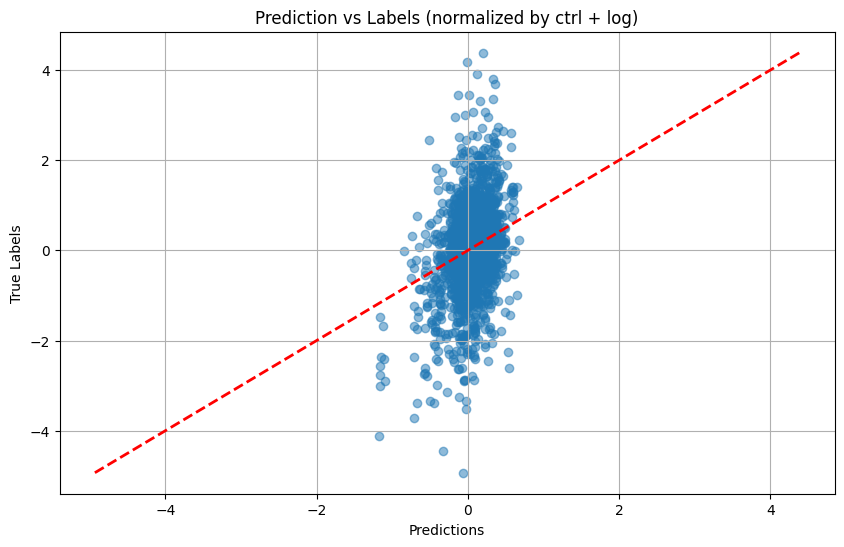

In [44]:
plot_predictions_vs_labels(predictions, labels, title='Prediction vs Labels (normalized by ctrl + log)')


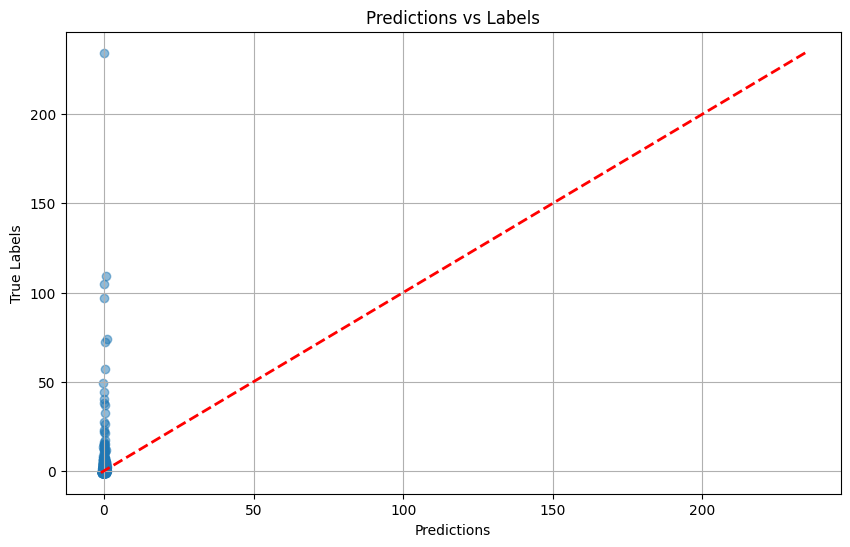

In [38]:
plot_predictions_vs_labels(predictions_inv, labels_inv)


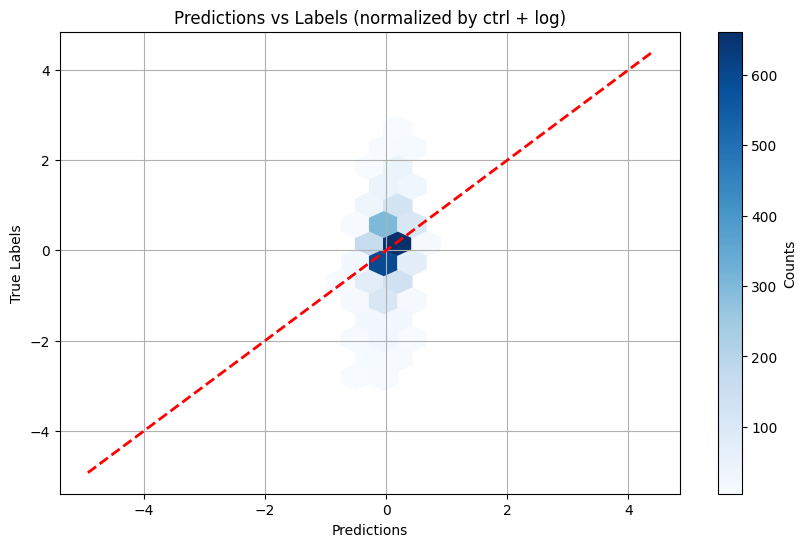

In [45]:
plot_hexbin_predictions_vs_labels(predictions, labels, title="Predictions vs Labels (normalized by ctrl + log)", gridsize=20, mincnt=5)

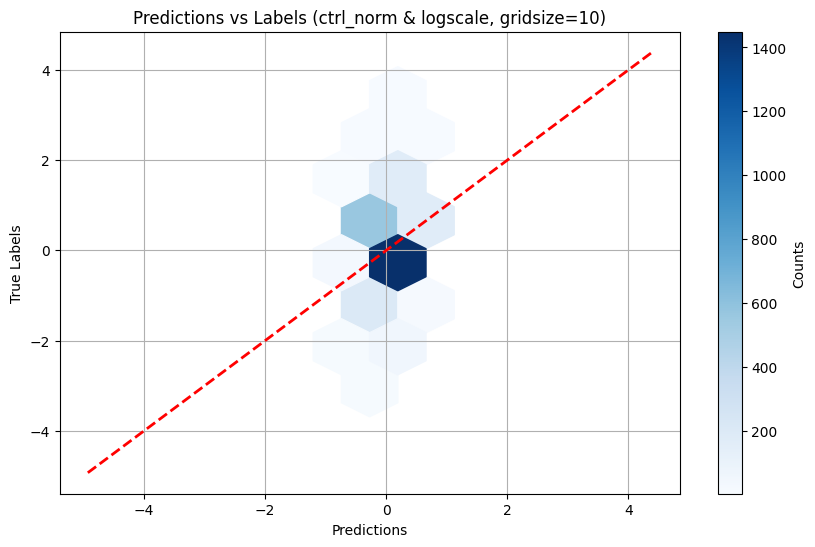

In [46]:
plot_hexbin_predictions_vs_labels(predictions, labels, title="Predictions vs Labels (ctrl_norm & logscale, gridsize=10)", gridsize=10, mincnt=5)

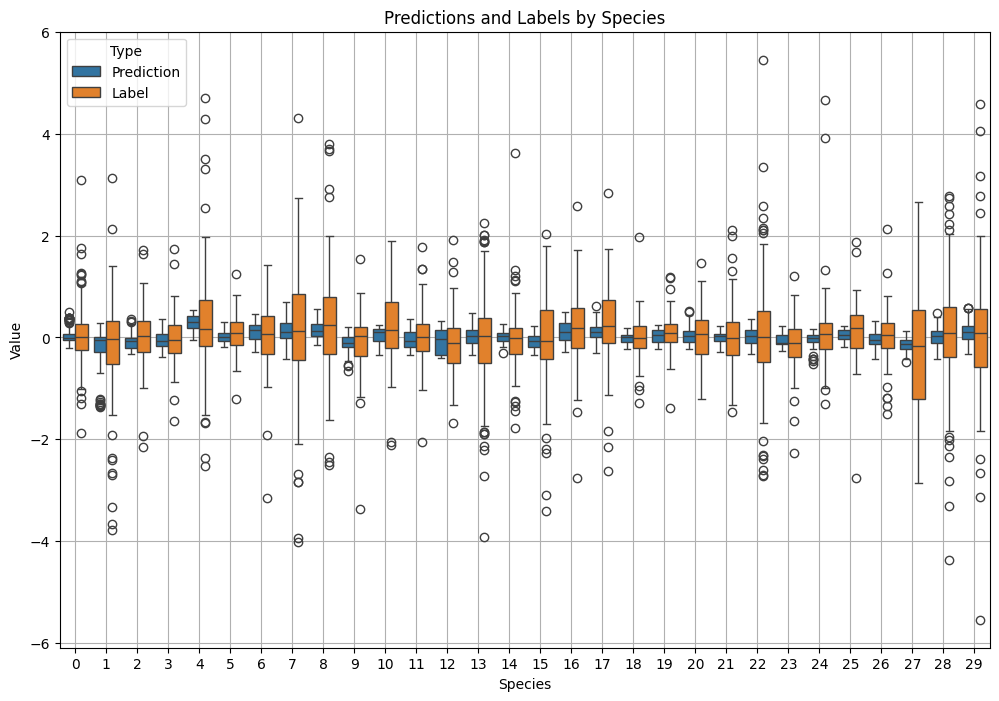

In [45]:
plot_boxplot_predictions_vs_labels(predictions, labels, species_ids, by_label='Species')

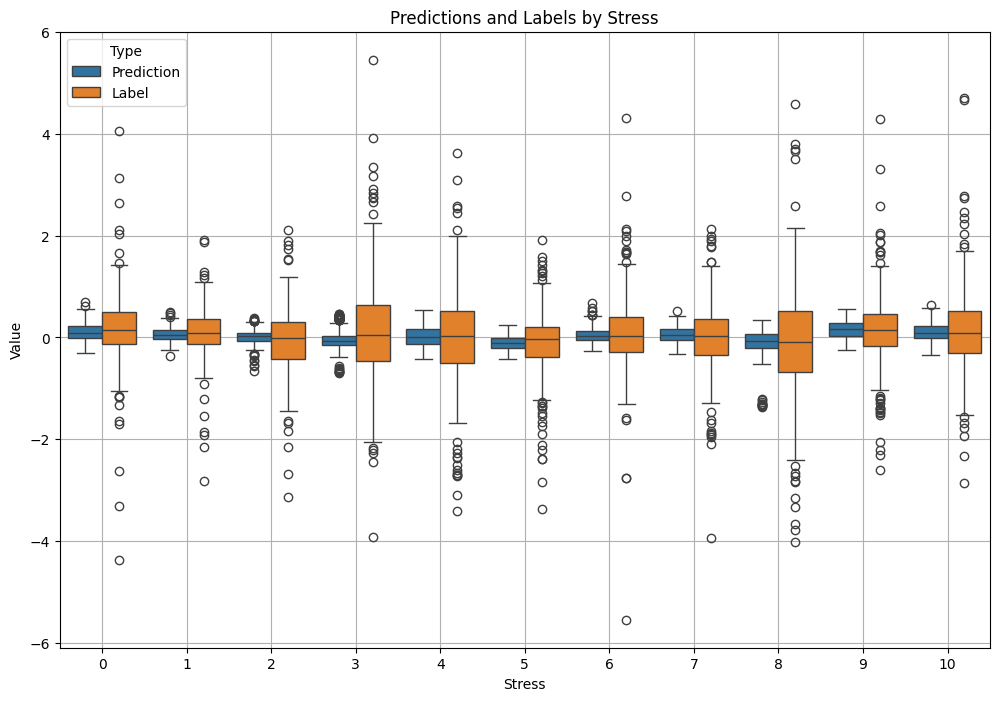

In [47]:
# Plot the boxplot
plot_boxplot_predictions_vs_labels(predictions, labels, all_stress_ids, by_label='Stress')

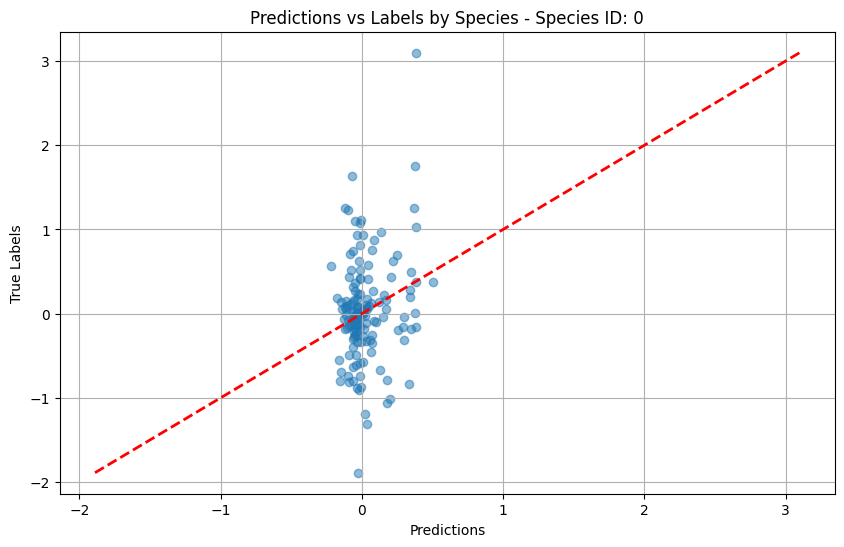

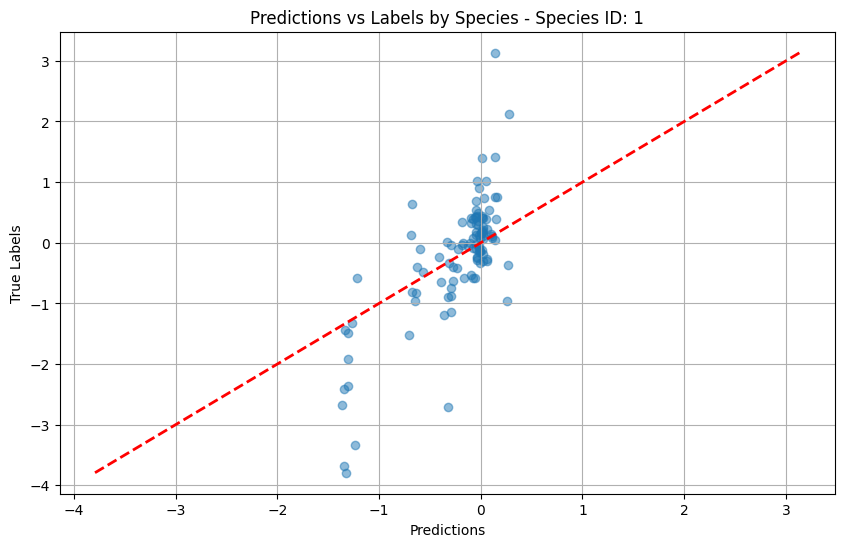

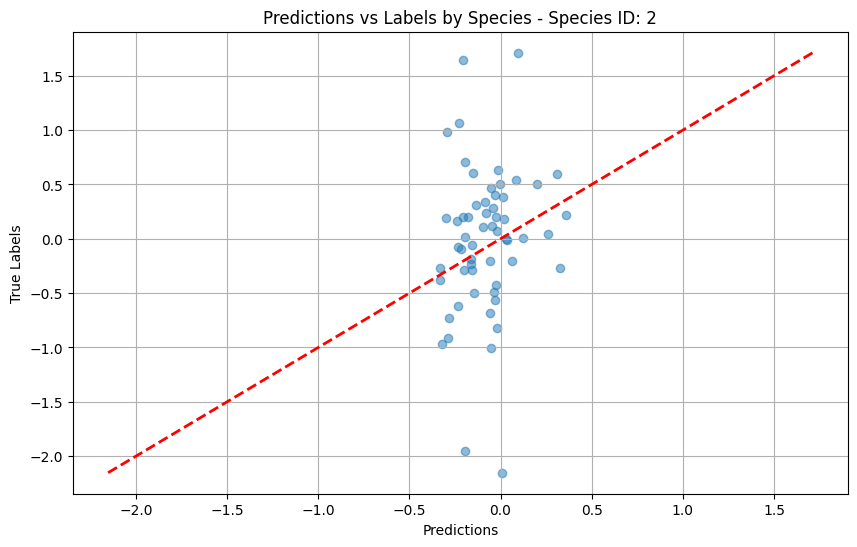

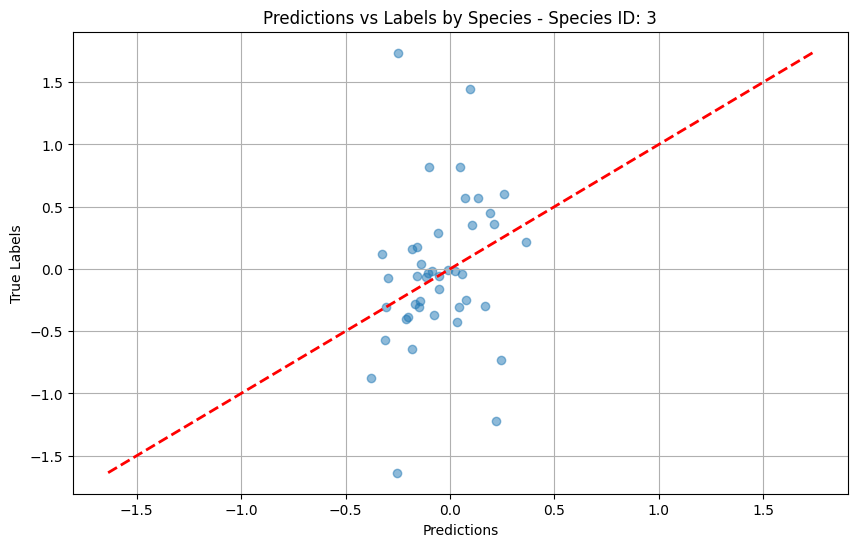

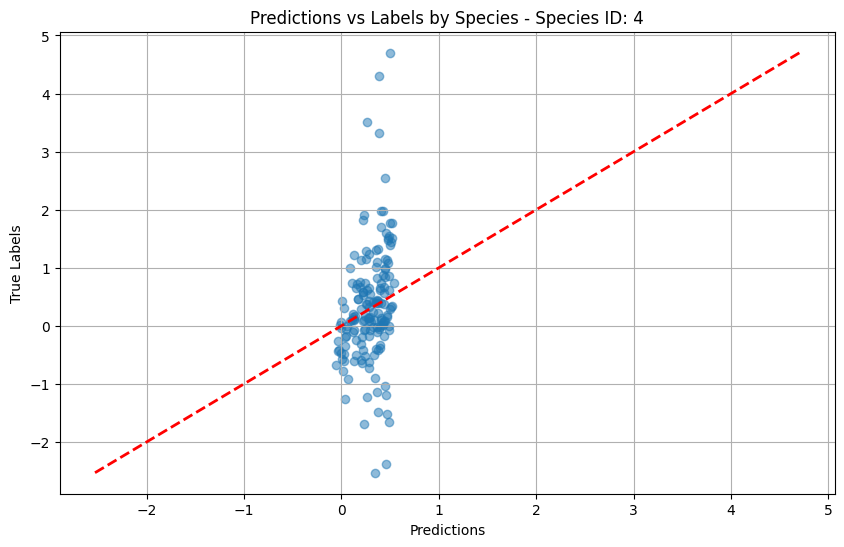

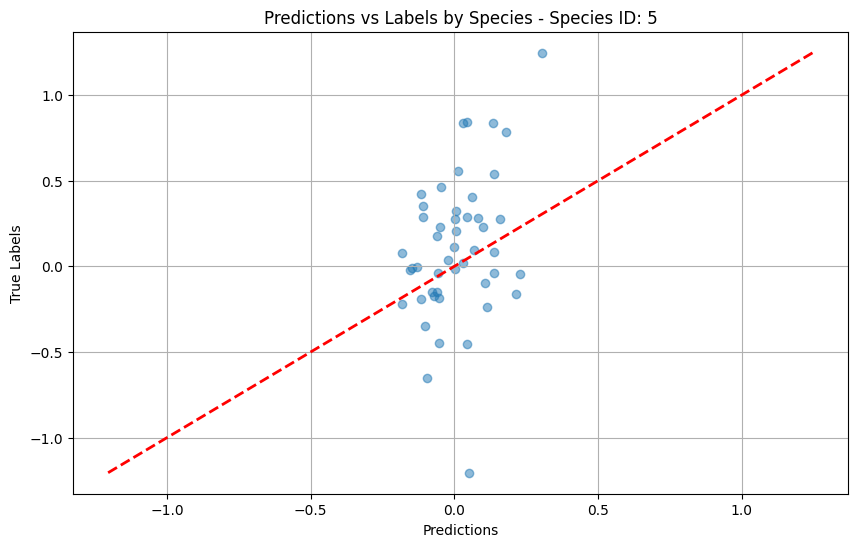

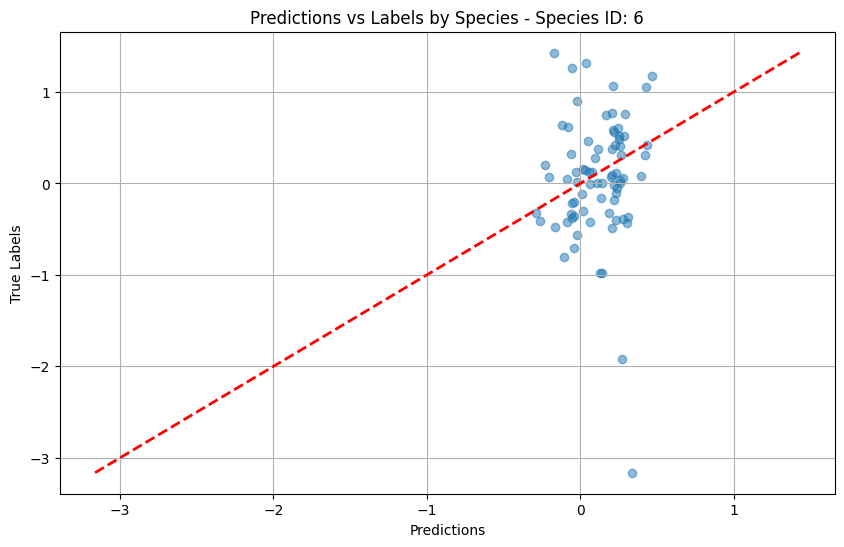

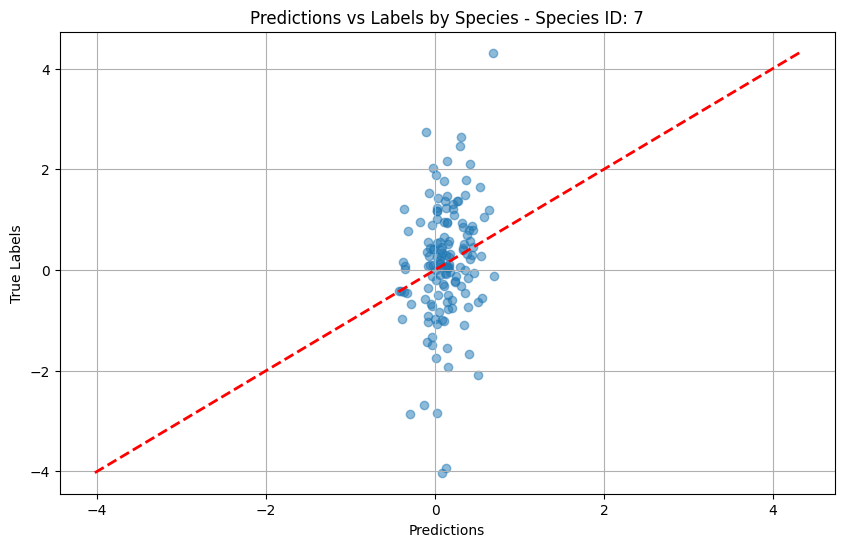

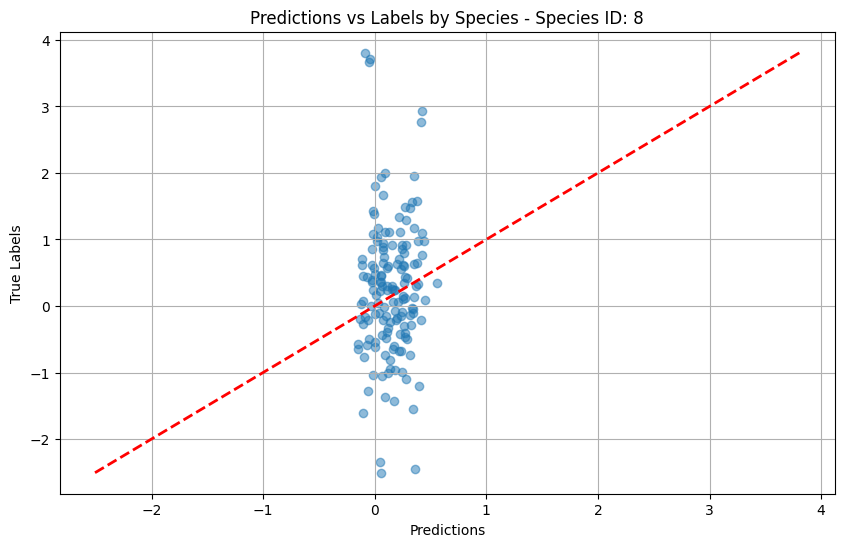

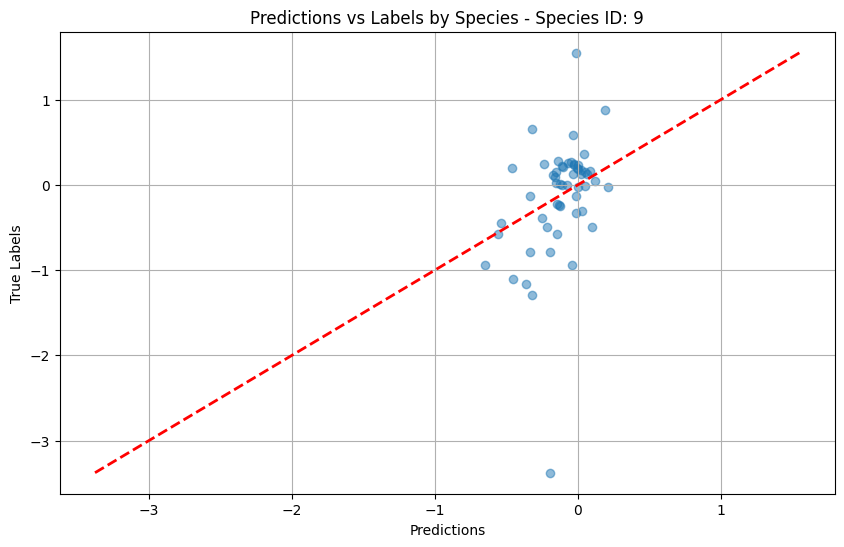

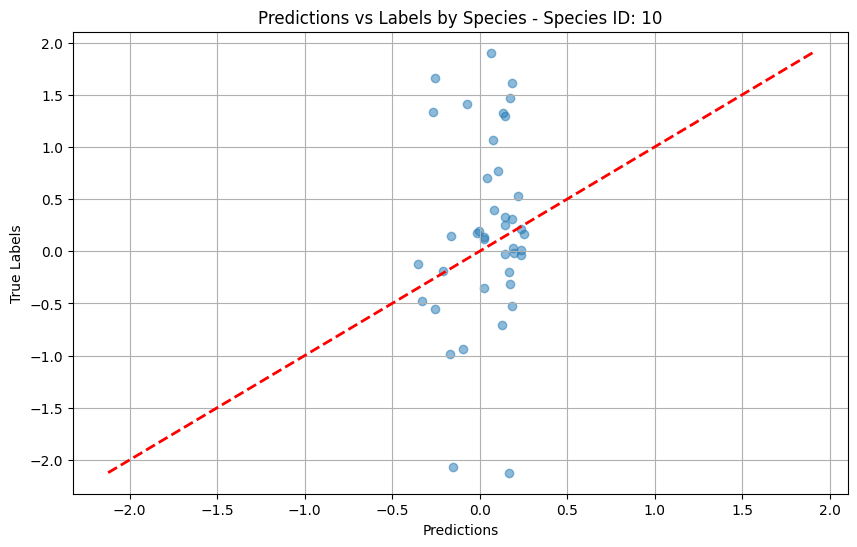

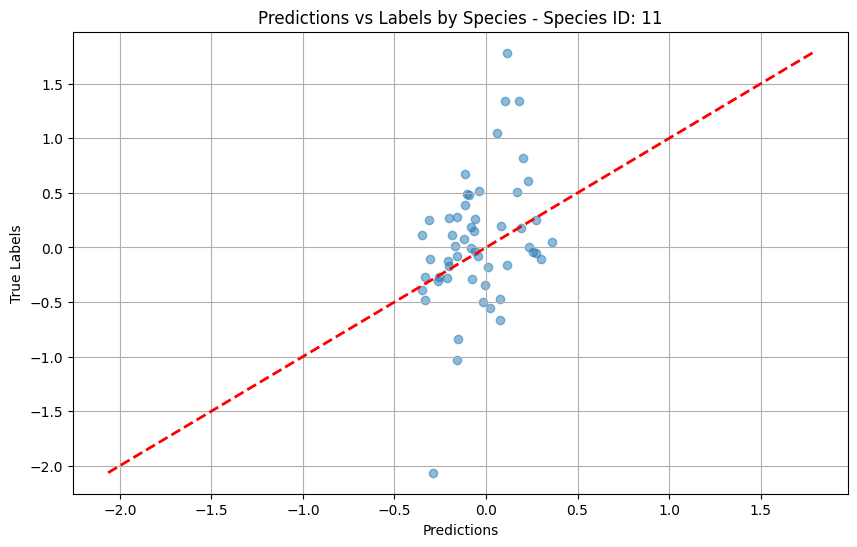

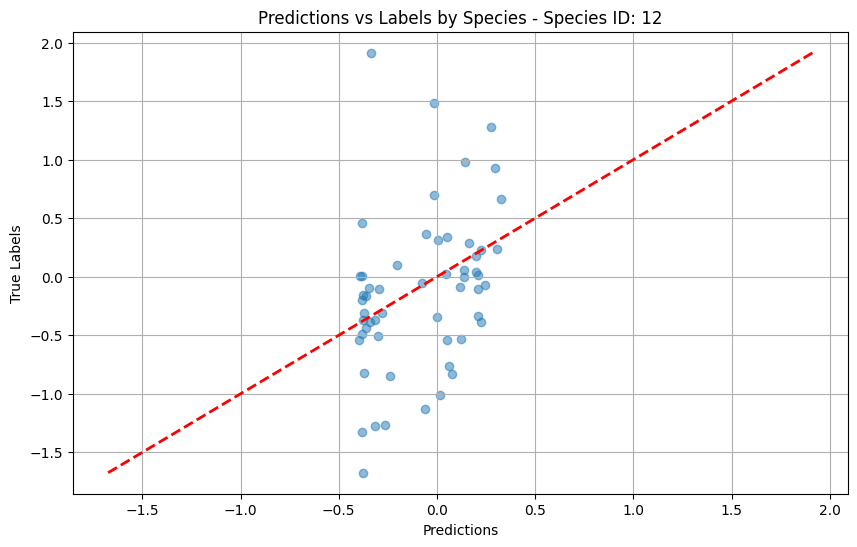

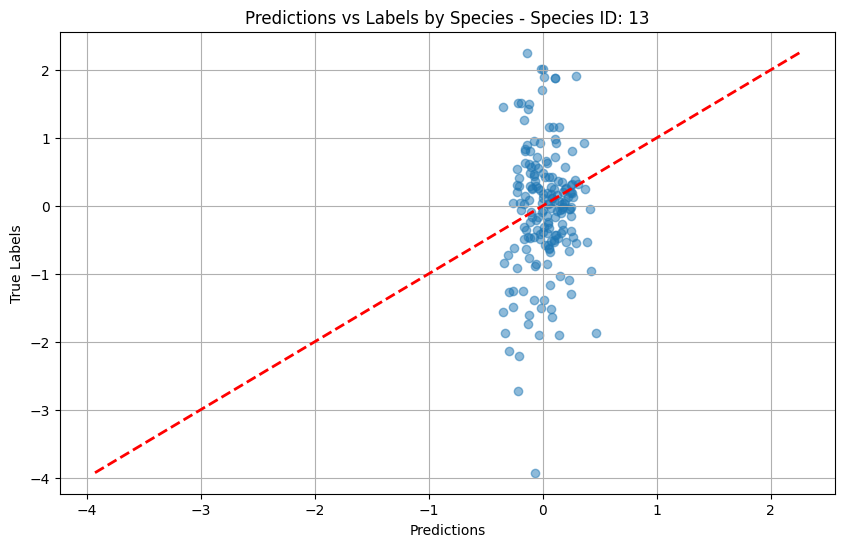

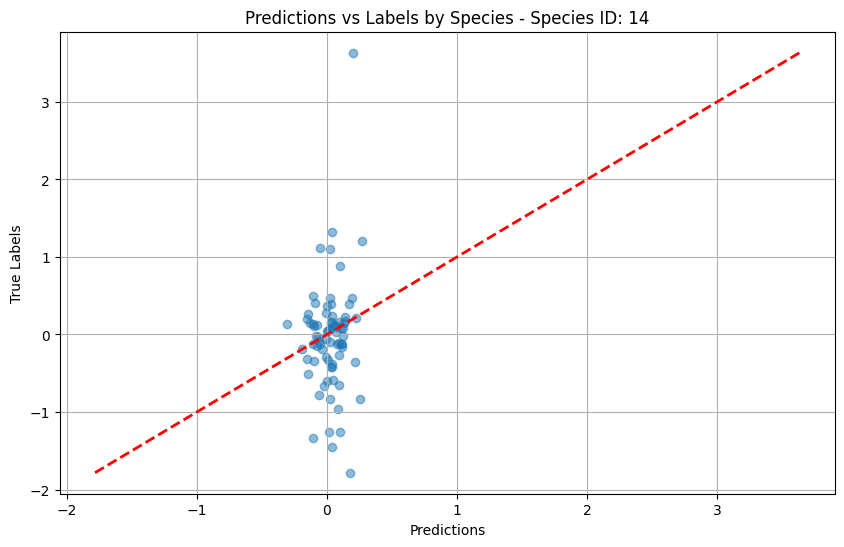

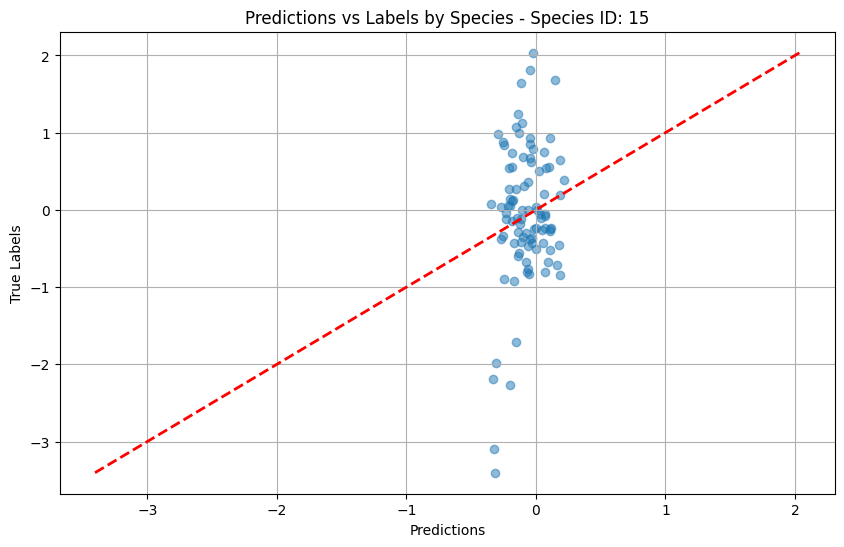

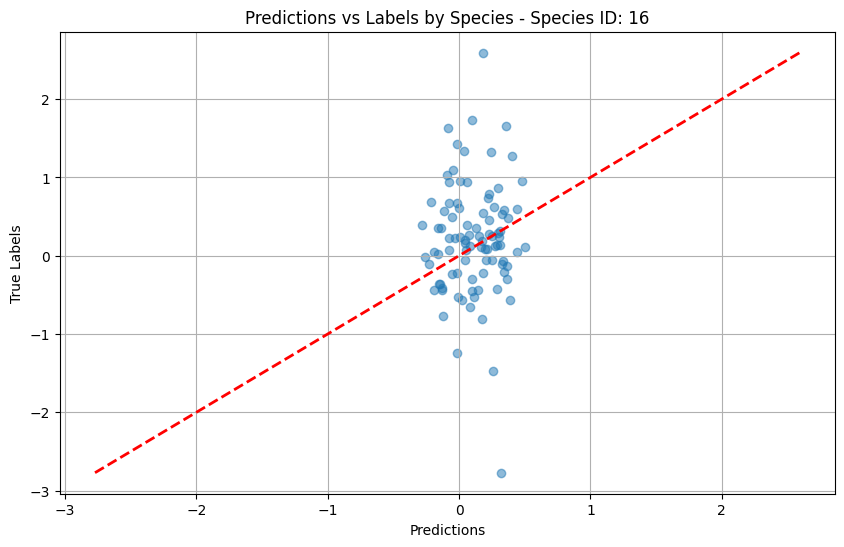

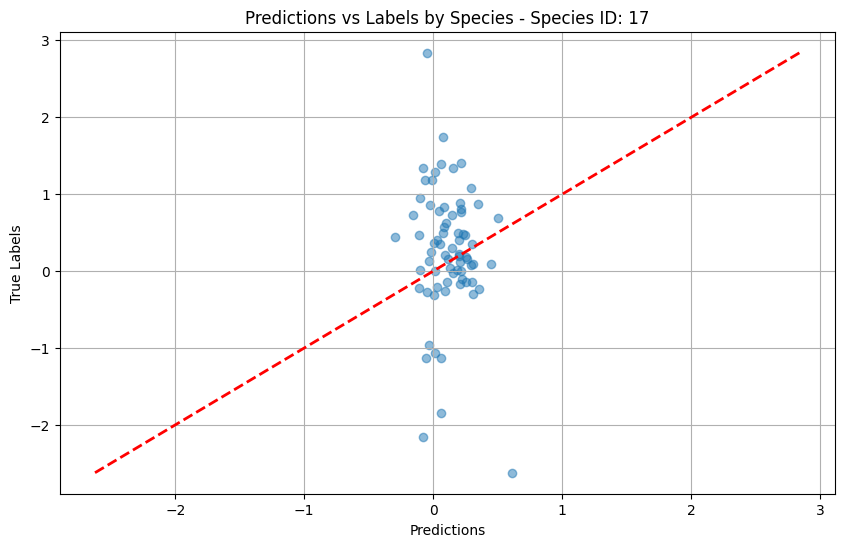

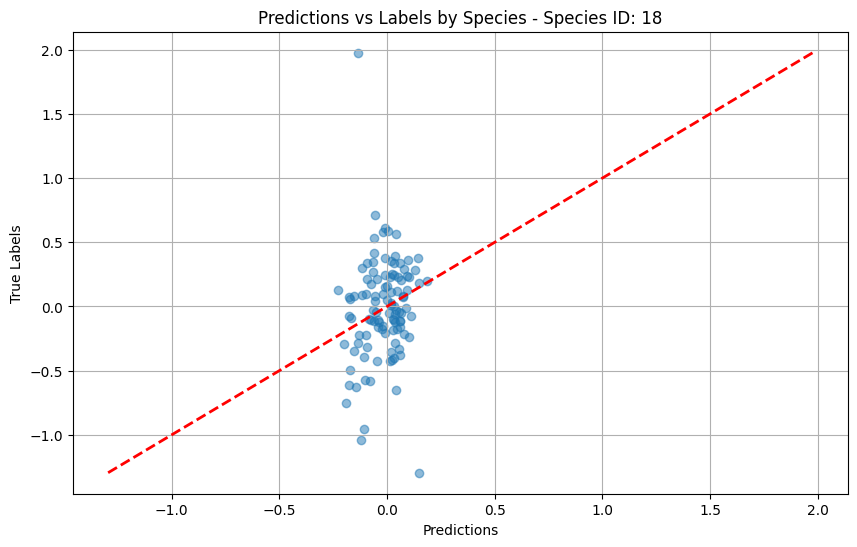

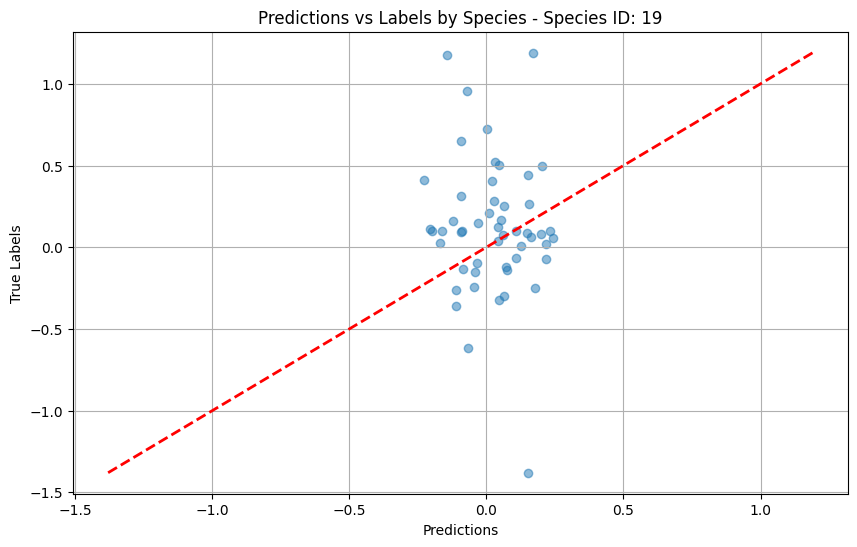

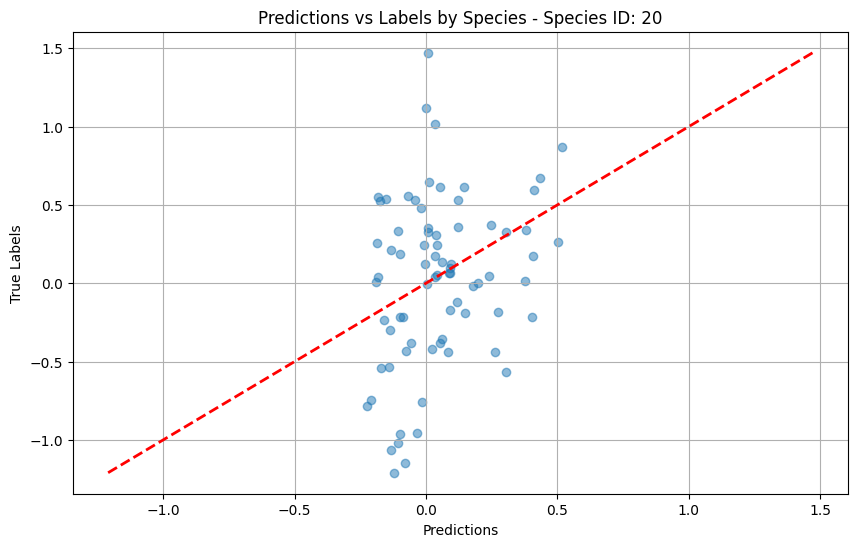

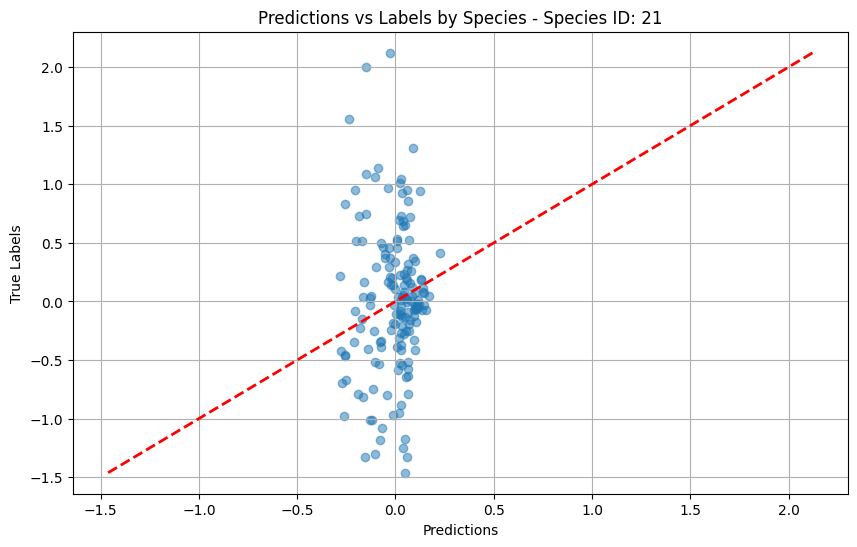

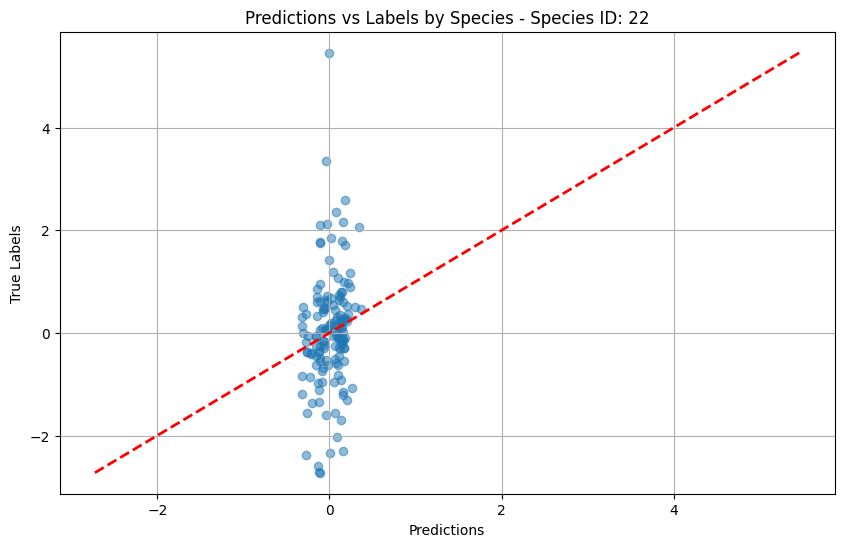

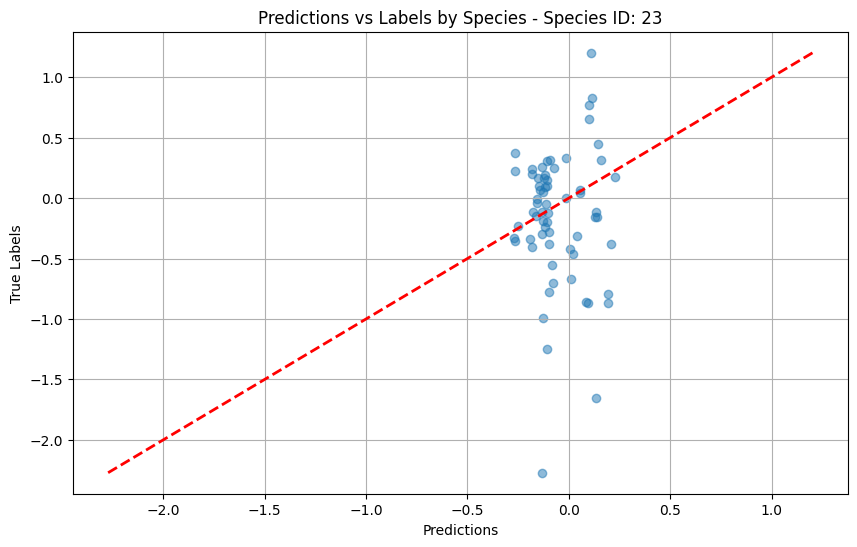

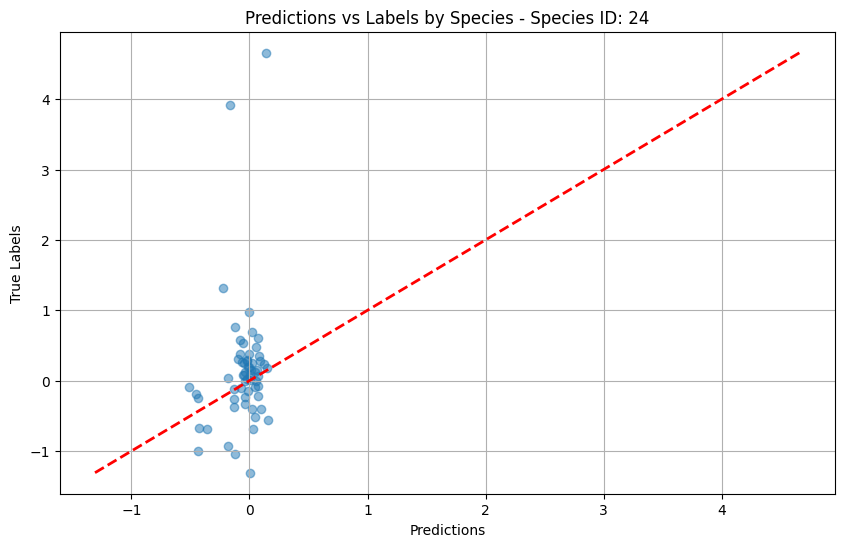

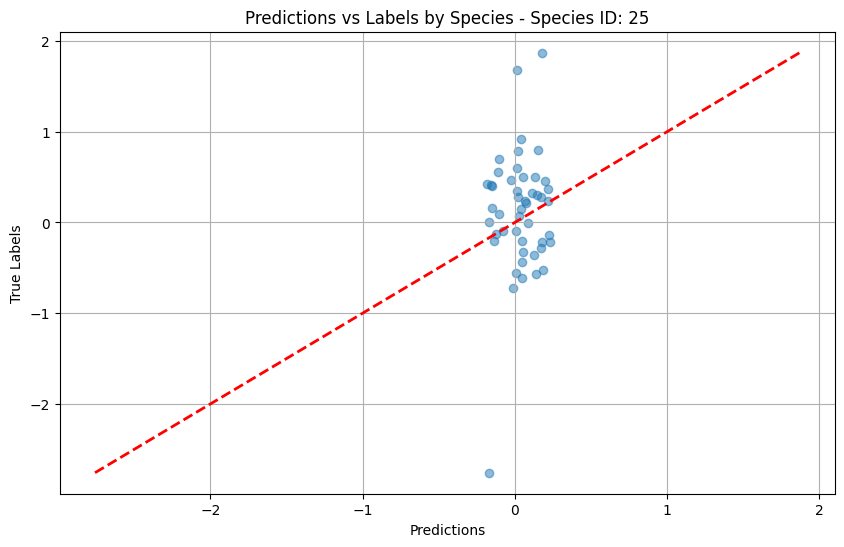

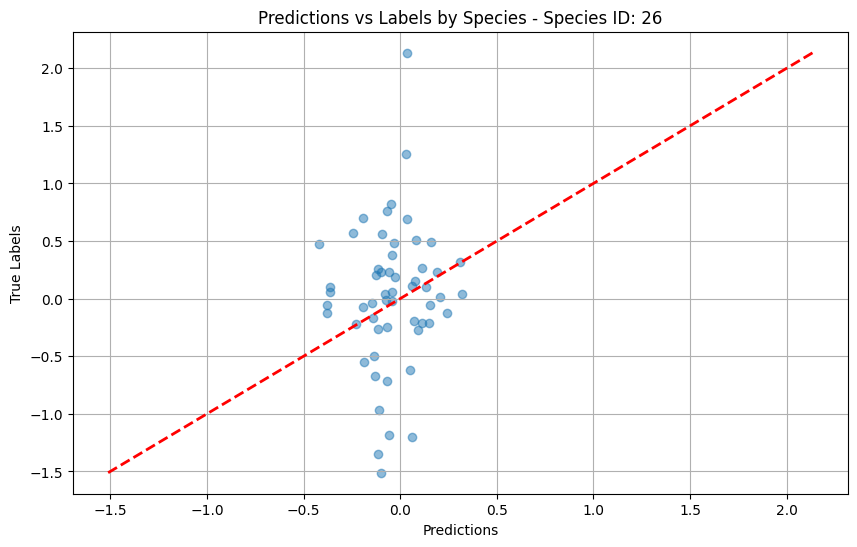

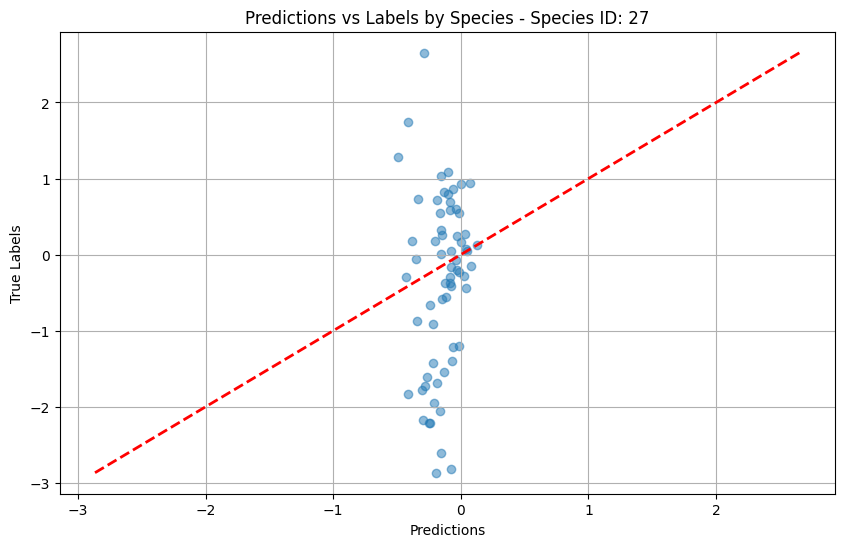

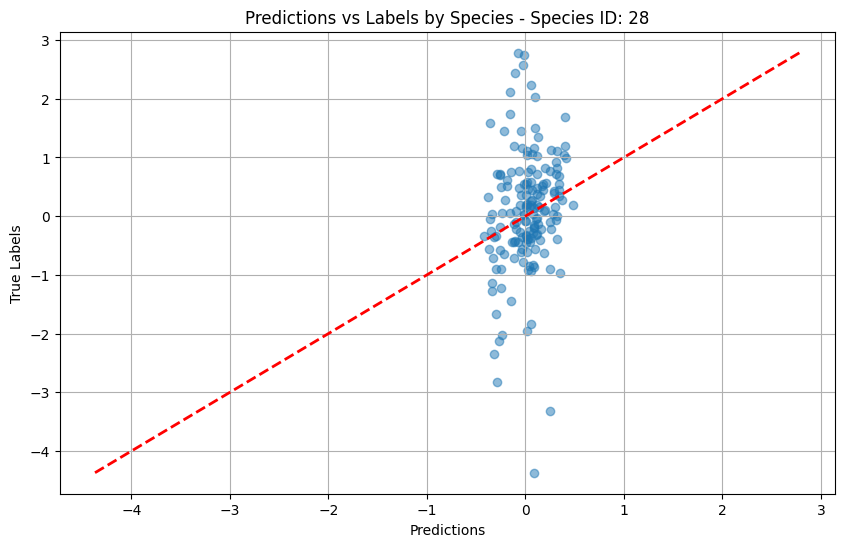

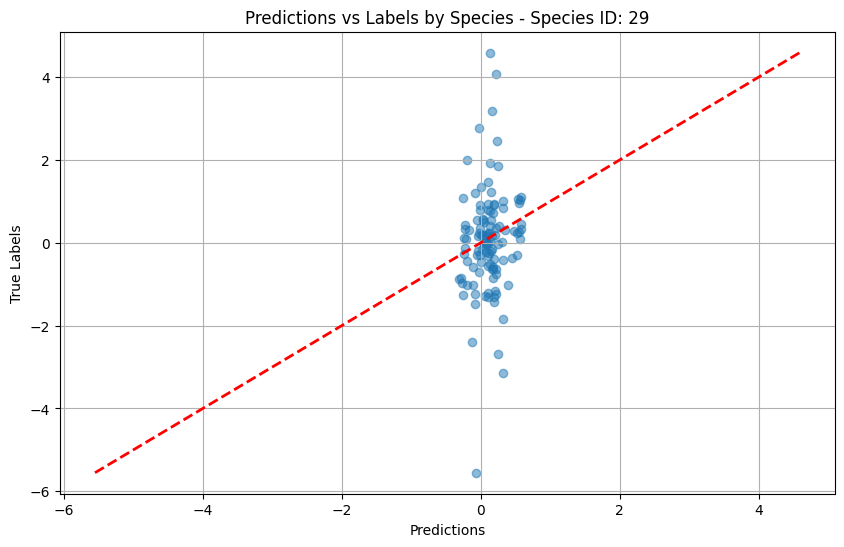

In [48]:
plot_predictions_vs_labels_by_species(predictions, labels, species_ids)


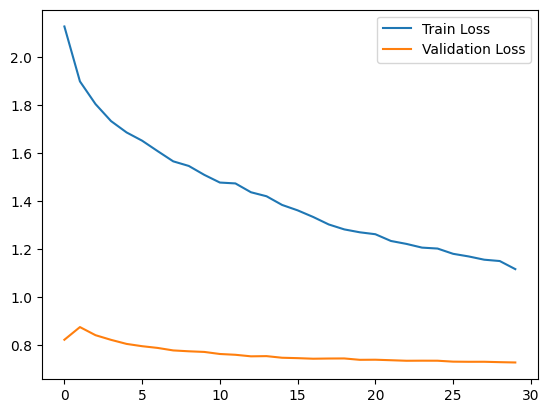

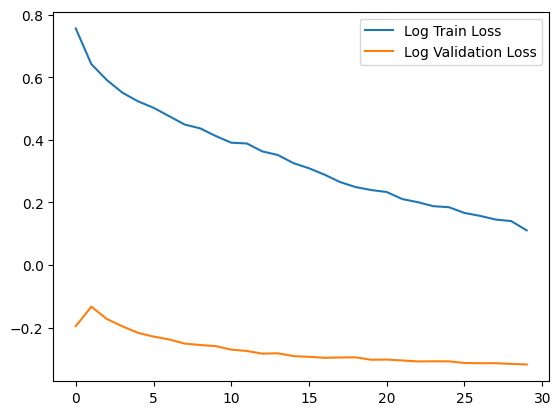

In [49]:
plot_losses(train_losses, val_losses)